In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set()
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from fim import apriori
from fim import fpgrowth

categ = pd.read_csv("ravdess_categorical.csv").replace(dict(vocal_channel=dict(GNAA=np.nan), actor=dict(GNAA=np.nan)))
quant = pd.read_csv("ravdess_quantitative.csv")

quant = quant.loc[np.logical_not(categ.vocal_channel.isna())]
categ = categ.loc[np.logical_not(categ.vocal_channel.isna())]#.drop(columns=["actor"])
# categ = categ.loc[np.logical_not(categ.actor.isna())]

categ.statement=pd.Categorical(categ.statement).codes.astype(str)

scaled_quant = pd.DataFrame(MinMaxScaler().fit_transform(quant.values), columns=quant.columns)
scaled_quant = quant

# X = scaled_quant.qcut(scaled_quant, 10)
categ.drop(columns=["estimated_vocal_channel"], inplace=True)

# Sets default font
rcParams['font.size'] = 9.0
rcParams['font.family'] = "sans-serif"
rcParams['legend.title_fontsize'] =  9
rcParams['legend.fontsize'] =  9
rcParams["figure.autolayout"] = False

In [37]:
q_binned_quant = pd.DataFrame()
e_binned_quant = pd.DataFrame()
binned_categ = pd.DataFrame()


levels_df = pd.DataFrame()

N_bins = 5
image_prefix = f"NBINS_{N_bins}"
 
categ_encoder = dict(emotional_intensity="ein", 
                    vocal_channel="voc", 
                    emotion="emo",
                    sex="sex",
                    actor="act",
                    statement="stm",
                    repetition="rep")
for feature in categ.columns:
    binned_categ[f"binned_{feature}"] = f"{categ_encoder[feature]}_" + categ[feature].astype(str)
    
##########################
for feature in scaled_quant.columns:
    levels_df[feature] = np.quantile(scaled_quant[feature], np.linspace(0,1,N_bins+1))
    q_binned_quant[f"quantile_binned_{feature}"] = f"{feature}_" + pd.qcut(scaled_quant[feature], N_bins).astype(str)
full_categ_quantile = q_binned_quant.join(binned_categ)
#####

## Number of FP with min_supp

## conditioned

here i study the number of frequent patterns in the dataset with known actors

In [38]:
supports=np.linspace(4,30,80)
excluded_cat_df = pd.DataFrame()
reference_df = pd.DataFrame()

X_complete = full_categ_quantile.loc[np.logical_not(categ.actor.isna())].values
for supp in supports:
    print(supp, end=" ")
    frequent_itemsets = apriori(X_complete, target="a", supp=supp, zmin=2, report="s")
    row=dict(support=supp, n_fp=len(frequent_itemsets))
    row=pd.DataFrame(row, index=[0])
    reference_df = pd.concat([reference_df, row], ignore_index=True)
    
    for cat in categ.columns:
        X_dropped_col = full_categ_quantile.drop(columns=f"binned_{cat}").loc[np.logical_not(categ.actor.isna())].values
        frequent_itemsets = apriori(X_dropped_col, target="s", supp=supp, zmin=2, report="s")
        row=dict(excluded_feature=cat, support=supp, n_fp=len(frequent_itemsets))
        row=pd.DataFrame(row, index=[0])
        excluded_cat_df = pd.concat([excluded_cat_df, row], ignore_index=True)

excluded_cat_df["ratio"]=0
for cat in categ.columns:
    excluded_cat_df["ratio"].loc[excluded_cat_df.excluded_feature==cat] = 100*excluded_cat_df["n_fp"].loc[excluded_cat_df.excluded_feature==cat].values/reference_df.n_fp.values

4.0 4.329113924050633 4.658227848101266 4.987341772151899 5.3164556962025316 5.6455696202531644 5.974683544303797 6.30379746835443 6.632911392405063 6.962025316455696 7.291139240506329 7.620253164556962 7.949367088607595 8.278481012658228 8.60759493670886 8.936708860759493 9.265822784810126 9.594936708860759 9.924050632911392 10.253164556962025 10.582278481012658 10.91139240506329 11.240506329113924 11.569620253164556 11.89873417721519 12.227848101265822 12.556962025316455 12.886075949367088 13.215189873417721 13.544303797468354 13.873417721518987 14.20253164556962 14.531645569620252 14.860759493670885 15.189873417721518 15.518987341772151 15.848101265822784 16.177215189873415 16.50632911392405 16.835443037974684 17.164556962025316 17.493670886075947 17.82278481012658 18.151898734177216 18.481012658227847 18.81012658227848 19.139240506329113 19.468354430379748 19.79746835443038 20.12658227848101 20.455696202531644 20.78481012658228 21.11392405063291 21.44303797468354 21.772151898734176

/tmp/ipykernel_11306/215518234.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excluded_cat_df["ratio"].loc[excluded_cat_df.excluded_feature==cat] = 100*excluded_cat_df["n_fp"].loc[excluded_cat_df.excluded_feature==cat].values/reference_df.n_fp.values


In [39]:
all_cat_df = pd.DataFrame()
supports=np.linspace(4,30,80)

X = full_categ_quantile.values
for zmin in [1,2,3,4]:
    print(zmin)
    for supp in supports:
        frequent_itemsets = apriori(X, target="a", supp=supp, zmin=zmin, report="s")
        row=dict(zmin=f"min. {zmin} item(s)", support=supp, n_fp=len(frequent_itemsets))
        row=pd.DataFrame(row, index=[0])
        all_cat_df = pd.concat([all_cat_df, row], ignore_index=True)

1
2
3
4


In [40]:
excluded_cat_df

,excluded_feature,support,n_fp,ratio
0,vocal_channel,4.0,7691,63.284786
1,emotion,4.0,11912,98.016951
2,emotional_intensity,4.0,8997,74.031103
3,statement,4.0,9588,78.894100
4,repetition,4.0,9624,79.190323
...,...,...,...,...
555,emotional_intensity,30.0,1,50.000000
556,statement,30.0,2,100.000000
557,repetition,30.0,2,100.000000
558,actor,30.0,2,100.000000


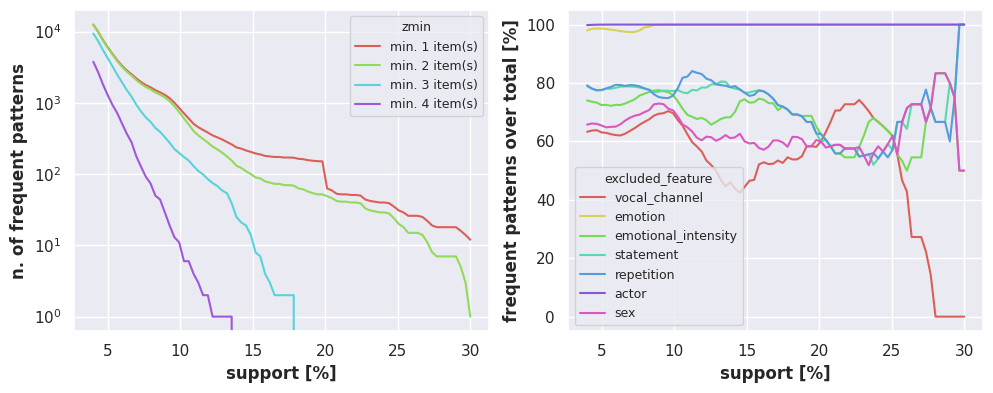

In [41]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(10,4))

sns.lineplot(data=all_cat_df, x="support", y="n_fp", hue="zmin", ax=ax1, palette="hls")
ax1.set_yscale("log")
ax1.set_ylabel("n. of frequent patterns", fontdict=dict(fontweight="bold"));
ax1.set_xlabel("support [%]", fontdict=dict(fontweight="bold"));

obj=sns.lineplot(data=excluded_cat_df,x="support", y="ratio", hue="excluded_feature", palette="hls", ax=ax2)

# ax2.set_yscale("log")
ax2.set_ylabel("frequent patterns over total [%]", fontdict=dict(fontweight="bold"));
ax2.set_xlabel("support [%]", fontdict=dict(fontweight="bold"));
fig.tight_layout()
fig.savefig(f"images/{image_prefix}fp_excluded.pdf")

## Rules

here i study the rules distribution in the whole dataset with the actor column removed

In [42]:
M = 30
lifts = np.zeros((M,M))
N_of_rules = np.zeros((M,M))

supports = np.linspace(5,30, M)
confidences = np.linspace(5, 75, M)
X = full_categ_quantile.drop(columns=["binned_actor"]).values
for i,supp in enumerate(supports):
    print(i, end= " ")
    for j,conf in enumerate(confidences):
        rules = apriori(X, target="r", supp=supp, zmin=2, conf=conf, report="aScl")
        rules_df = pd.DataFrame(
            rules,
            columns=[
                "consequent",
                "antecedent",
                "abs_support",
                "%_support",
                "confidence",
                "lift",
            ],
        )
        lifts[i,j] = np.mean(rules_df.lift)
        N_of_rules[i,j] = len(rules_df)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

/tmp/ipykernel_11306/2030210174.py:6: RuntimeWarning: divide by zero encountered in log10
  sns.heatmap(np.log10(N_of_rules), vmin=0,  cmap=cmap, ax=axN, rasterized=True)


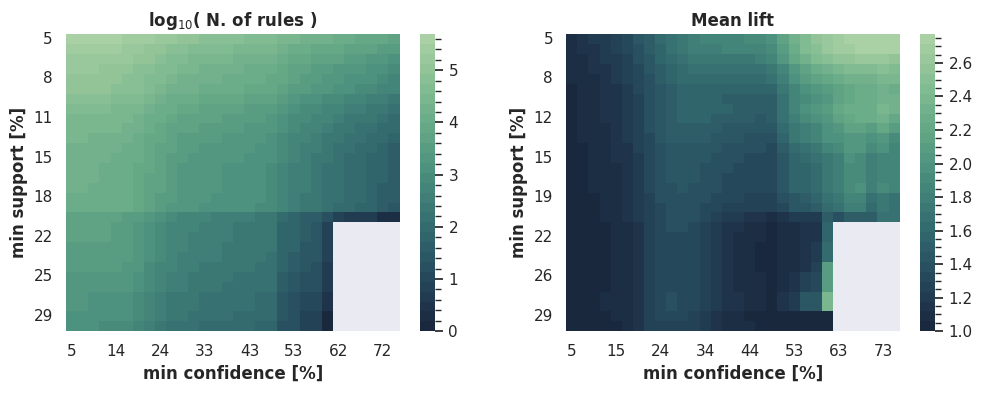

In [43]:
fig, (axN, axmeanL) = plt.subplots(1,2, figsize=(10,4))

cmap =  sns.cubehelix_palette(n_colors=30, rot=-0.5, light=0.75, reverse=True)


sns.heatmap(np.log10(N_of_rules), vmin=0,  cmap=cmap, ax=axN, rasterized=True)
thin = 4
xticks = (np.arange(0,M)+0.5)[::thin]
yticks = (np.arange(0,M)+0.5)[::thin]
xtickslabels = [f"{np.floor(u).astype(int)}" for u in confidences[::thin]]
ytickslabels = [f"{np.floor(u).astype(int)}" for u in supports[::thin]]
axN.set_xticks( xticks, xtickslabels,rotation=0);
axN.set_yticks( yticks, ytickslabels,rotation=0);
axN.set_xlabel("min confidence [%]", fontdict=dict(fontweight="bold"));
axN.set_ylabel("min support [%]", fontdict=dict(fontweight="bold"));
axN.set_title(r"log$_{10}$( N. of rules )",fontdict=dict(fontweight="bold"))
fig.tight_layout()

sns.heatmap(lifts, vmin=1, cmap=cmap, ax=axmeanL,  rasterized=True)
xticks = (np.arange(0,M)+0.5)[::thin]
yticks = (np.arange(0,M)+0.5)[::thin]
xtickslabels = [f"{round(u)}" for u in confidences][::thin]
ytickslabels = [f"{round(u)}" for u in supports][::thin]
axmeanL.set_xticks( xticks, xtickslabels, rotation=0);
axmeanL.set_yticks( yticks, ytickslabels, rotation=0);
axmeanL.set_xlabel("min confidence [%]", fontdict=dict(fontweight="bold"));
axmeanL.set_ylabel("min support [%]", fontdict=dict(fontweight="bold"));
axmeanL.set_title("Mean lift",fontdict=dict(fontweight="bold"))

fig.tight_layout()
fig.subplots_adjust(wspace=0.2)
fig.savefig(f"images/{image_prefix}heatmap_actor_removed.pdf")

## Classification?

here i study the test dataset (95%) with the actor column removed

In [44]:
classification_rule_df = pd.DataFrame()
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(full_categ_quantile.values, test_size=0.05)

full_categ_quantile_train = pd.DataFrame(X_train, columns=full_categ_quantile.columns)
full_categ_quantile_test = pd.DataFrame(X_test, columns=full_categ_quantile.columns)

In [45]:
X = full_categ_quantile_train.drop(columns=["binned_actor"]).values
rules_stats_df_lift = pd.DataFrame()
for conf in [20, 35, 50]:
    supp = 5
    rules = apriori(X, target="r", supp=supp, zmin=2, conf=conf, report="aScl")
    partial_df = pd.DataFrame(
        rules,
        columns=[
            "consequent",
            "antecedent",
            "abs_support",
            "%_support",
            "confidence",
            "lift",
        ],
    )
    partial_df["threshold"] = f"confidence > {conf:}"
    rules_stats_df_lift = pd.concat([rules_stats_df_lift, partial_df], ignore_index=True)

X = full_categ_quantile_train.drop(columns=["binned_actor"]).values
rules_stats_df_conf = pd.DataFrame()
for supp in [4,10,15]:
    conf=10
    rules = apriori(X, target="r", supp=supp, zmin=2, conf=conf, report="aScl")
    partial_df = pd.DataFrame(
        rules,
        columns=[
            "consequent",
            "antecedent",
            "abs_support",
            "%_support",
            "confidence",
            "lift",
        ],
    )
    partial_df["threshold"] = f"support > {supp:2}"
    rules_stats_df_conf = pd.concat([rules_stats_df_conf, partial_df], ignore_index=True)

/tmp/ipykernel_11306/833513780.py:3: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.histplot(data=rules_stats_df_lift, x="lift", hue="threshold",fill=False, stat="count",element="step", ax=ax1, palette=pal)
/tmp/ipykernel_11306/833513780.py:9: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.histplot(data=rules_stats_df_conf, x="confidence",hue="threshold", fill=False, stat="count", element="step",  ax=ax2, palette=pal)


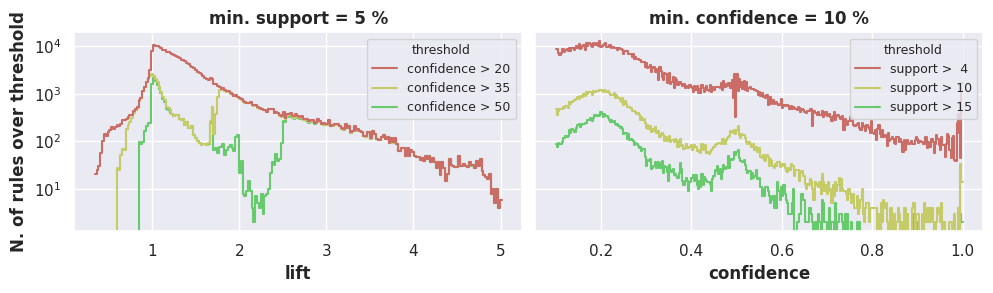

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3), sharey=True)
pal = sns.color_palette("hls", desat=.75)
sns.histplot(data=rules_stats_df_lift, x="lift", hue="threshold",fill=False, stat="count",element="step", ax=ax1, palette=pal)
ax1.set_xlabel("lift", fontdict=dict(fontweight="bold"));
ax1.set_title("min. support = 5 %", fontdict=dict(fontweight="bold"));
ax1.set_yscale("log")
ax1.set_ylabel("N. of rules over threshold", fontdict=dict(fontweight="bold"));

sns.histplot(data=rules_stats_df_conf, x="confidence",hue="threshold", fill=False, stat="count", element="step",  ax=ax2, palette=pal)
ax2.set_xlabel("confidence", fontdict=dict(fontweight="bold"));
# ax2.set_ylabel("", fontdict=dict(fontweight="bold"));
ax2.set_yscale("log")
ax2.set_title("min. confidence = 10 %", fontdict=dict(fontweight="bold"));

fig.tight_layout()
fig.savefig(f"images/{image_prefix}lift_conf_distrib.pdf")

In [62]:
X = full_categ_quantile_train.drop(columns=["binned_actor"]).values
cons_supp = 4
cons_conf = 50
rules = apriori(X, target="r", supp=cons_supp, zmin=2, conf=cons_conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)

In [63]:
rules_prevalence_df = pd.DataFrame()
for cat in categ.columns:
    for label in np.unique(categ[cat].apply(str)):
        encoded = categ_encoder[cat] + "_" + str(label)
        prevalence = np.sum(rules_df.consequent == encoded)
        mean_lift = rules_df[rules_df.consequent == encoded].lift.mean()
        mean_confidence = rules_df[rules_df.consequent == encoded].confidence.mean()
        
        row = dict(cat=cat, label=label, prevalence=prevalence, mean_lift=mean_lift, mean_confidence=mean_confidence)
        row = pd.DataFrame(row, index= [0])
        rules_prevalence_df = pd.concat([rules_prevalence_df, row], ignore_index=True)

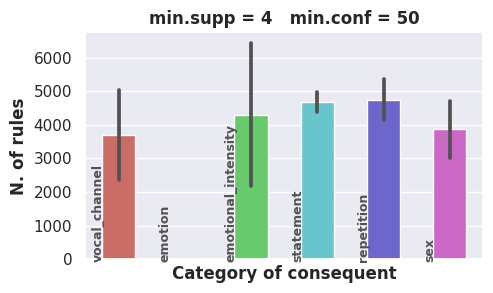

In [64]:
fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(data=rules_prevalence_df[rules_prevalence_df.cat != "actor"],
            x="cat", 
            y="prevalence",
            dodge=True,
            palette="hls", errcolor=".32", width=0.5,ax=ax)
ax.set_ylabel("N. of rules", fontdict=dict(fontweight="bold"))
ax.set_xlabel("Category of consequent", fontdict=dict(fontweight="bold"))

ax.set_xticks([])
cols = list(categ.columns.values)
cols.remove("actor")
for i, cat in enumerate(cols):
    ax.annotate(cat, (i-0.3, 0), rotation=90, color=".32", fontweight="bold", ha="center")
ax.set_title(f"min.supp = {cons_supp}   min.conf = {cons_conf}", fontdict=dict(fontweight="bold"))
fig.tight_layout()
fig.savefig(f"images/{image_prefix}_SUPP{cons_supp}_CONF{cons_conf}r_ule_count.pdf")

In [50]:
from sklearn.preprocessing import OneHotEncoder
predict_category = "binned_sex"
category_values = 2

onehot = OneHotEncoder().fit(full_categ_quantile_train[predict_category].values.reshape(-1,1))
test_features = full_categ_quantile_test.drop(columns=predict_category).columns
interesting_rules = np.zeros(len(rules_df)).astype(bool)
for label in np.unique(full_categ_quantile_train[predict_category].values):
    interesting_rules |= (rules_df.consequent == label)
rules_df.loc[interesting_rules].sort_values("confidence")

,consequent,antecedent,abs_support,%_support,confidence,lift
857476,sex_M,"(mfcc_max_(126.25, 176.357], sc_skew_(0.251, 0...",5,0.235294,0.050000,0.099114
930445,sex_M,"(log_stft_min_(-3.876, -3.371], mfcc_mean_(-42...",6,0.282353,0.050000,0.099114
539734,sex_M,"(stft_mean_(0.248, 0.404], voc_song, stm_0)",7,0.329412,0.050000,0.099114
421504,sex_F,"(stft_std_(0.209, 0.313], sc_max_(-0.001, 0.294])",5,0.235294,0.050000,0.100902
504347,sex_F,"(mfcc_max_(221.481, 280.174], sc_max_(0.294, 0...",5,0.235294,0.050505,0.101921
...,...,...,...,...,...,...
107750,sex_F,"(length_ms_(4638.0, 6373.0], stft_std_(0.352, ...",97,4.564706,1.000000,2.018044
107719,sex_F,"(length_ms_(4638.0, 6373.0], stft_std_(0.352, ...",97,4.564706,1.000000,2.018044
387165,sex_M,"(stft_std_(0.209, 0.313], log_stft_min_(-2.441...",135,6.352941,1.000000,1.982276
532314,sex_F,"(stft_mean_(0.248, 0.404], mfcc_max_(126.25, 1...",94,4.423529,1.000000,2.018044


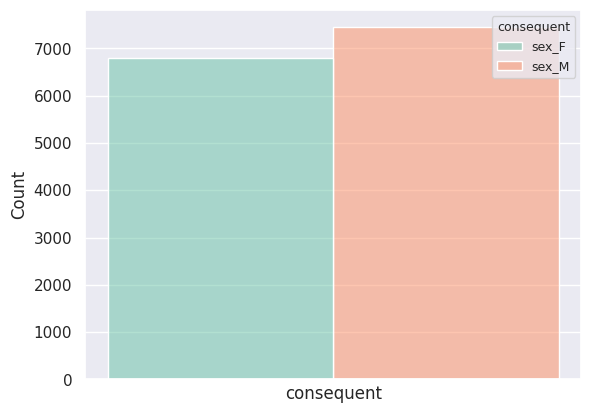

In [51]:
sns.histplot(data=rules_df.loc[interesting_rules], x="consequent", hue="consequent", palette="Set2")
plt.xticks([]);

In [52]:
predictions = np.zeros((len(full_categ_quantile_test), category_values))
N_rules = np.sum(interesting_rules)

for record_id, record in full_categ_quantile_test.drop(columns=predict_category).iterrows():
    print(record_id, end=" ")
    for rule_index, rule in rules_df.loc[interesting_rules].iterrows():
        # print(rule.lift)
        all_antecedent_match = True
        for antecedent in rule.antecedent:
            if antecedent not in record.values:
                all_antecedent_match = False
                break
        if all_antecedent_match:
            # print(f"rule {rule.antecedent} --> {rule.consequent} matched {row.values}")
            predictions[record_id] += onehot.transform([[rule.consequent]]).toarray()[0]*rule.lift

0 1 

KeyboardInterrupt: 

<AxesSubplot: >

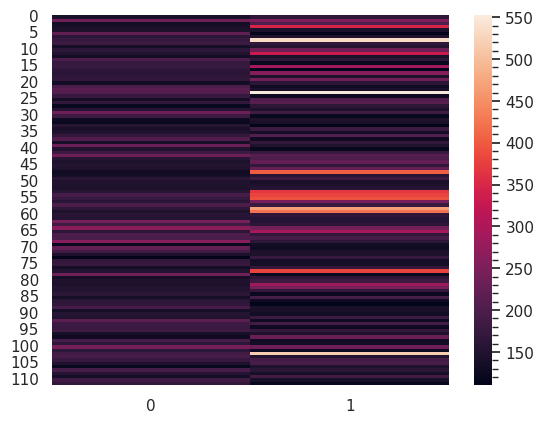

In [ ]:
sns.heatmap(predictions)

<AxesSubplot: >

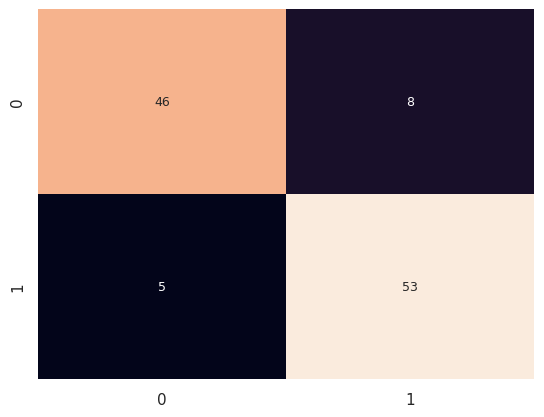

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

predictions_collapsed = np.argmax(predictions, axis=1)
predictions_onehot = np.zeros((len(predictions_collapsed), category_values))
for i in range(len(predictions)):
    predictions_onehot[i, predictions_collapsed[i]] = 1
predictions_label = onehot.inverse_transform(predictions_onehot).reshape(-1)
true_values = full_categ_quantile_test[predict_category].values
cfm = confusion_matrix(true_values, predictions_label)
sns.heatmap(cfm, cbar=False, annot=True)

In [ ]:
(predictions_label=="stm_0").sum()

0

In [ ]:
from sklearn.metrics import accuracy_score, recall_score
results_df = pd.DataFrame(dict(accuracy=accuracy_score(true_values, predictions_label), 
                                recall=recall_score(true_values, predictions_label, pos_label="sex_M")), 
                            index=[predict_category])
classification_rule_df = pd.concat([classification_rule_df, results_df])

In [ ]:
classification_rule_df

,accuracy,recall
binned_sex,0.883929,0.913793
